<a href="https://colab.research.google.com/github/sshar180/Machine-Learning-/blob/main/ResNet_Model_Data_Augmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Shubham Sharma

SID: 862394567

**Question 1) (3 pts) Train your Resnet model without augmentation and report the results.**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

"""
Below load_data method can have multiple values of type for data augmentation.

type = "Normal" For no augmentation

type = "Cutout" For Cutout augmentation

type = "Standard" For Standard augmentation

"""

def load_data(type = 'Normal'):
    trainset = None
    testset = None

    if type == "Cutout":
      print("Cutout")
      transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      Cutout(16),#Randomly masking out a square region of size 16x16 pixels in the image
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

      trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
      testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    elif type == "Standard":
      print("Standard")
      transform_train = transforms.Compose([
      StandardAugmentation(4),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

      trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
      testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    elif type == "Cutout_Standard":
      print("Cutout_Standard")
      transform_train = transforms.Compose([
          StandardAugmentation(4),
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          Cutout(16),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

      trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
      testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    else:
      print("*******************Normal***************")
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
      trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
      testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    """Sampling 1,000 examples uniformly at random out of 5,000 for each class"""
    indices = torch.randperm(len(trainset))[:10000]
    subset_trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


    return trainloader, testloader

""" Initializing the resnet20 model"""
def initialize_model():
    resnet20 = models.resnet18(pretrained=False)
    resnet20.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    resnet20.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

    return resnet20


def plot_results(train_losses, train_accs, test_accs, num_epochs, text = ''):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Training Loss over Epochs {text}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"Training and Test Accuracy over Epochs {text}")
    plt.legend()
    plt.show()

    # print('Finished Training')

In [ ]:
""" Resnet train method

Parameters:

model-> The resnet20 model

trainloader -> train data

testloader -> test data

num_epochs -> Number of epochs, learning_rate -> learning rate

cre -> This can have two values "Normal" and "Mixup". "Normal" when there is no mixup augmentation and "Mixup" when we have mixup augmentation.

alpha  -> Beta distribution parameter for Mixing ratio.
"""
def train_model(model, trainloader, testloader, num_epochs=100, learning_rate=0.001 , cre = "Normal", alpha = 0.2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accs = []
    test_accs = []

    """Using the cross-entropy loss and the Adam optimizer,"""
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = None
            loss = None
            if cre == "Mixup":
              # print("Mixup")
              inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha, device)
              outputs = model(inputs)
              loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            else:
              # print("Normal")
              outputs = model(inputs)
              loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total

        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total

        if cre == "Mixup":
          print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Training Accuracy: {train_acc}, Test Accuracy {test_acc} for alpha = {alpha}")
        else:
          print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Training Accuracy: {train_acc}, Test Accuracy {test_acc}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    return train_losses, train_accs, test_accs


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training Loss: 1.834959564694933, Training Accuracy: 0.3332, Test Accuracy 0.4092
Epoch 2, Training Loss: 1.4607149028474358, Training Accuracy: 0.4713, Test Accuracy 0.5042
Epoch 3, Training Loss: 1.290500310575886, Training Accuracy: 0.5385, Test Accuracy 0.5488
Epoch 4, Training Loss: 1.116477566919509, Training Accuracy: 0.6074, Test Accuracy 0.5658
Epoch 5, Training Loss: 0.9671466088598701, Training Accuracy: 0.6583, Test Accuracy 0.6279
Epoch 6, Training Loss: 0.8177880610630011, Training Accuracy: 0.7103, Test Accuracy 0.637
Epoch 7, Training Loss: 0.67837927219974, Training Accuracy: 0.7599, Test Accuracy 0.6406
Epoch 8, Training Loss: 0.5340319393546717, Training Accuracy: 0.8116, Test Accuracy 0.6348
Epoch 9, Training Loss: 0.4065492032629669, Training Accuracy: 0.8589, Test Accuracy 0.644
Epoch 10, Training Loss: 0.28983579196368053, Training Accuracy: 0.9015, Test Accuracy 0.654
Epoch 11, 

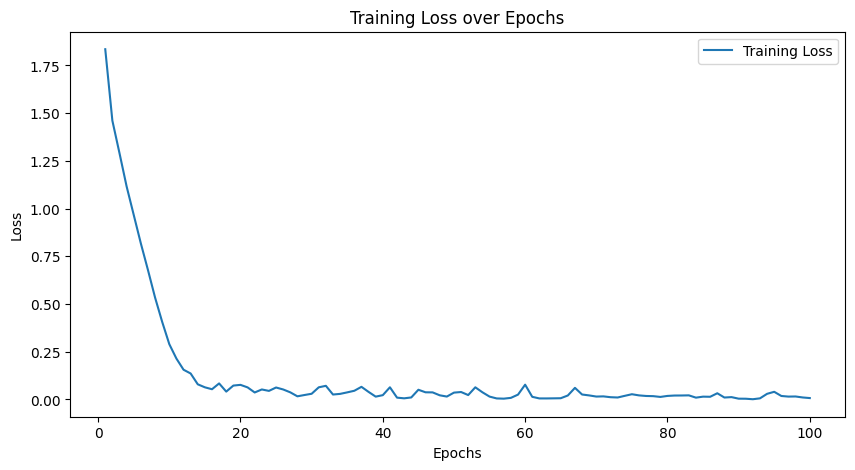

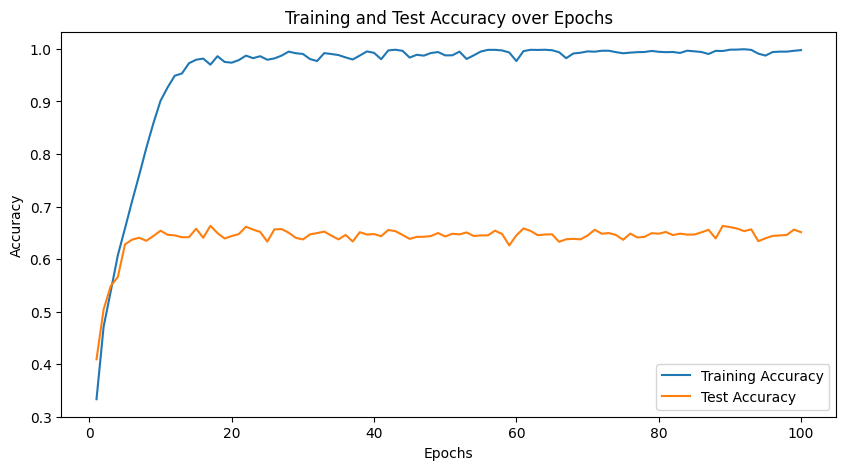

Finished Training


In [ ]:
"""Loading data without any data without augmentation"""
trainloader, testloader = load_data()

"""Model Initialization"""
resnet20 = initialize_model()

"""Model Training"""
train_losses, train_accs, test_accs = train_model(resnet20, trainloader, testloader, num_epochs=100, learning_rate=0.001)

"""Plot Train and Test Accuracy"""
plot_results(train_losses, train_accs, test_accs, num_epochs=100)


**Question 2)(4 pts) Mixup augmentation is based on the paper https://arxiv.org/pdf/1710.09412.pdf. As the
name suggests, it mixes a pair of training examples (both inputs and labels). Given a pair of training
example (x1, y1), (x2, y2), we obtain the augmented training example (x, y) via
x = λx1 + (1 − λ)x2 y = λy1 + (1 − λ)y2
where mixing parameter λ has β distribution1 with parameter α.
TODO: Implement mixup and report the results for α = 0.2 and α = 0.4. Note that, in each minibatch,
all training examples should have mixup transformation before gradient calculation (e.g. from original
minibatch obtain a new minibatch by mixing random pairs of training examples).**

*******************Normal***************
Files already downloaded and verified
Files already downloaded and verified
--------******-----------    Started Training ---------*******-----------
Epoch 1, Training Loss: 1.7013576440750413, Training Accuracy: 0.2764, Test Accuracy 0.5123 for alpha = 0.2
Epoch 2, Training Loss: 1.4318269529160421, Training Accuracy: 0.3494, Test Accuracy 0.5587 for alpha = 0.2
Epoch 3, Training Loss: 1.242071292582591, Training Accuracy: 0.3523, Test Accuracy 0.5757 for alpha = 0.2
Epoch 4, Training Loss: 1.1744531827747442, Training Accuracy: 0.4222, Test Accuracy 0.6346 for alpha = 0.2
Epoch 5, Training Loss: 0.9501946997490658, Training Accuracy: 0.459, Test Accuracy 0.6587 for alpha = 0.2
Epoch 6, Training Loss: 0.9057611640851209, Training Accuracy: 0.4698, Test Accuracy 0.6601 for alpha = 0.2
Epoch 7, Training Loss: 0.7288864412505156, Training Accuracy: 0.447, Test Accuracy 0.6692 for alpha = 0.2
Epoch 8, Training Loss: 0.7564427279363013, Training Acc

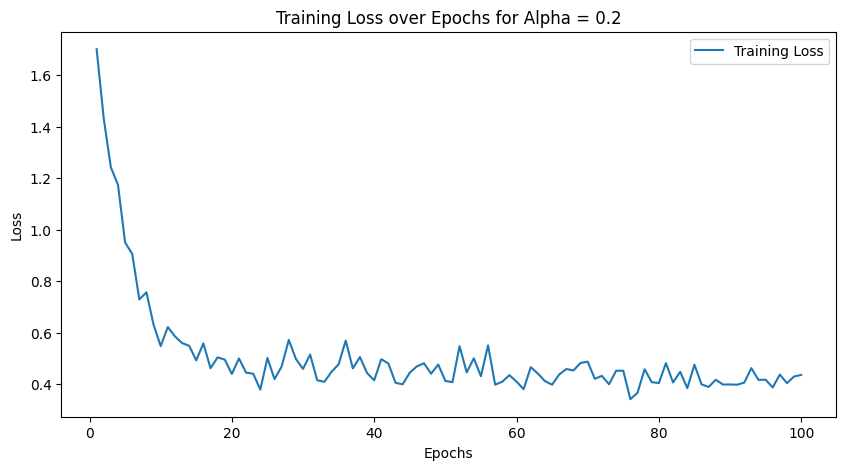

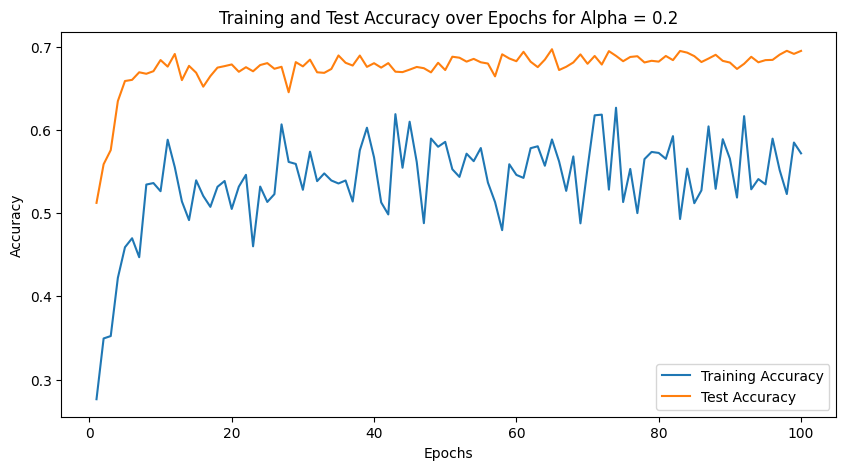

--------******-----------    Finished Training ---------*******-----------
--------******-----------    Started Training ---------*******-----------
Epoch 1, Training Loss: 1.820283148698746, Training Accuracy: 0.2386, Test Accuracy 0.4708 for alpha = 0.4
Epoch 2, Training Loss: 1.5823510945982235, Training Accuracy: 0.3396, Test Accuracy 0.5461 for alpha = 0.4
Epoch 3, Training Loss: 1.3992331487357996, Training Accuracy: 0.3688, Test Accuracy 0.6185 for alpha = 0.4
Epoch 4, Training Loss: 1.2476057899985344, Training Accuracy: 0.4071, Test Accuracy 0.63 for alpha = 0.4
Epoch 5, Training Loss: 1.199755130679744, Training Accuracy: 0.4532, Test Accuracy 0.6492 for alpha = 0.4
Epoch 6, Training Loss: 1.127713415653083, Training Accuracy: 0.4856, Test Accuracy 0.6622 for alpha = 0.4
Epoch 7, Training Loss: 0.9446524943515753, Training Accuracy: 0.5077, Test Accuracy 0.6615 for alpha = 0.4
Epoch 8, Training Loss: 0.8784960878502791, Training Accuracy: 0.4783, Test Accuracy 0.6517 for alph

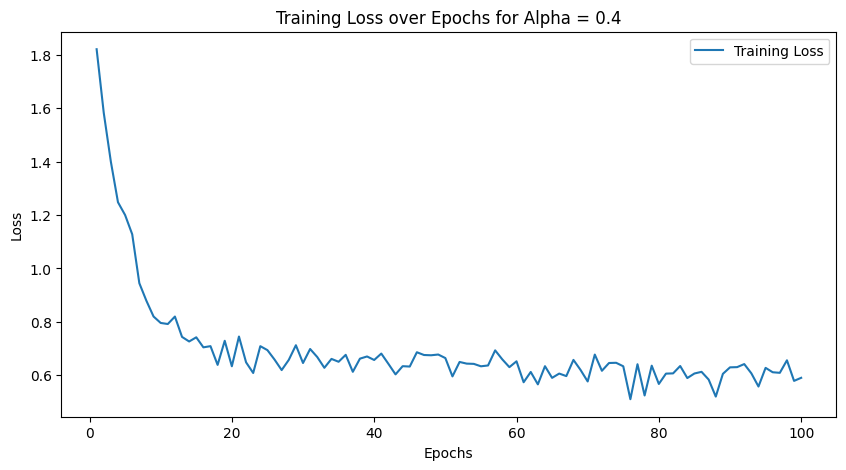

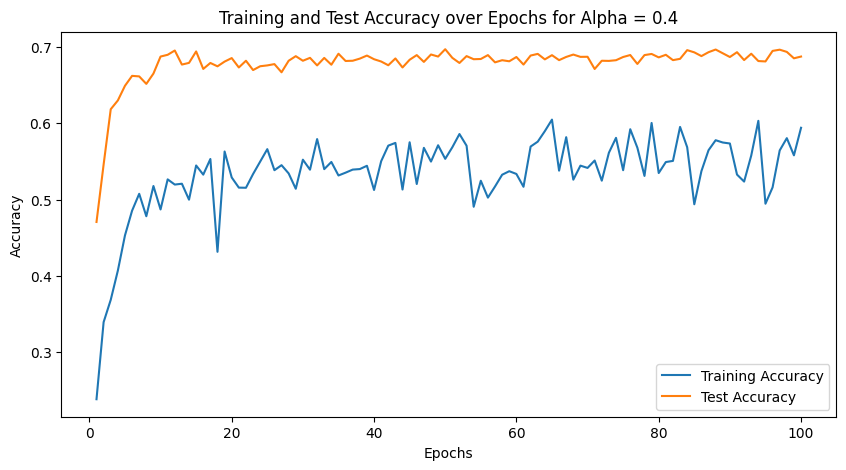

--------******-----------    Finished Training ---------*******-----------


In [ ]:
import numpy as np

"""Mixup Function"""
def mixup_data(x, y, alpha, device):
    """Random sampling from a beta distribution"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    """Random permutation of indices"""
    index = torch.randperm(batch_size).to(device)
    """Linear Interpolation of original and pair image"""
    mixed_x = lam * x + (1 - lam) * x[index, :]
    """Label Extraction"""
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def Answer2():
    trainloader, testloader = load_data()
    num_epochs = 100
    alphas = [0.2, 0.4]

    for alpha in alphas:
      model = initialize_model()
      print("--------******-----------    Started Training ---------*******-----------")
      train_losses, train_accs, test_accs = train_model(model, trainloader, testloader, num_epochs = num_epochs , learning_rate=0.001 , cre = "Mixup", alpha = alpha)
      """Plot Train and Test Accuracy"""
      plot_results(train_losses, train_accs, test_accs, num_epochs= num_epochs, text = f"for Alpha = {alpha}")
      print('--------******-----------    Finished Training ---------*******-----------')

Answer2()


Answer 2) The experiment shows that mixup data augmentation can significantly increase the accuracy of a model. The accuracy increased from 65% to 69% when mixup data augmentation was used. However, the accuracy was almost similar for two different alpha values, 0.2 and 0.4.

Overall, the experiment shows that mixup data augmentation can be an effective way to improve the accuracy of a model. The choice of alpha value may not have a significant impact on the accuracy of the model.







**Question 3) . (4 pts) Cutout augmentation is based on the paper https://arxiv.org/pdf/1708.04552.pdf. For
each training image with 50% probability you keep the image intact. With 50% probability, select a
random pixel which serves as the center of your cutout mask. Then, set the square mask of size K × K
pixels around this center pixel to be zero. Note that part of the mask is allowed to be outside of the
image. For visualization, see Figure 1 of the paper.
TODO: Implement and use cutout augmentation with K = 16 and report the results.**

In [ ]:
class Cutout:
    def __init__(self, length):
        """Setting the length of Cutout mask"""
        self.length = length

    def __call__(self, img):
        """Getting the height h and the width w from the img"""
        h, w = img.size(1), img.size(2)
        """Creating mask as same shape as the image filled with onces"""
        mask = np.ones((h, w), np.float32)
        """Random y coordinate selection"""
        y = np.random.randint(h)
        """Random x coordinate selection"""
        x = np.random.randint(w)
        """Starting co-ordinate of cutout mask"""
        y1 = np.clip(y - self.length // 2, 0, h)
        """end co-ordinate of cutout mask"""
        y2 = np.clip(y + self.length // 2, 0, h)
        """Starting co-ordinate of cutout mask"""
        x1 = np.clip(x - self.length // 2, 0, w)
        """End co-ordinate of cutout mask"""
        x2 = np.clip(x + self.length // 2, 0, w)
        mask[y1:y2, x1:x2] = 0
        """Converting to pytorch"""
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        """Applying cutout mask in the input image"""
        img *= mask
        return img

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training Loss: 1.8702705597421925, Training Accuracy: 0.303, Test Accuracy 0.3872
Epoch 2, Training Loss: 1.6323623793899633, Training Accuracy: 0.3986, Test Accuracy 0.4355
Epoch 3, Training Loss: 1.489855671384532, Training Accuracy: 0.4535, Test Accuracy 0.4845
Epoch 4, Training Loss: 1.4144972259071982, Training Accuracy: 0.4873, Test Accuracy 0.5352
Epoch 5, Training Loss: 1.3271952370169815, Training Accuracy: 0.5221, Test Accuracy 0.5549
Epoch 6, Training Loss: 1.2669623038571352, Training Accuracy: 0.5434, Test Accuracy 0.5796
Epoch 7, Training Loss: 1.1945706742584326, Training Accuracy: 0.5737, Test Accuracy 0.6044
Epoch 8, Training Loss: 1.153949135807669, Training Accuracy: 0.5874, Test Accuracy 0.5977
Epoch 9, Training Loss: 1.100812410093417, Training Accuracy: 0.6065, Test Accuracy 0.6223
Epoch 10, Training Loss: 1.0547922625663175, Training Accuracy: 0.6228, Test Accuracy 0.6329
Epoch 1

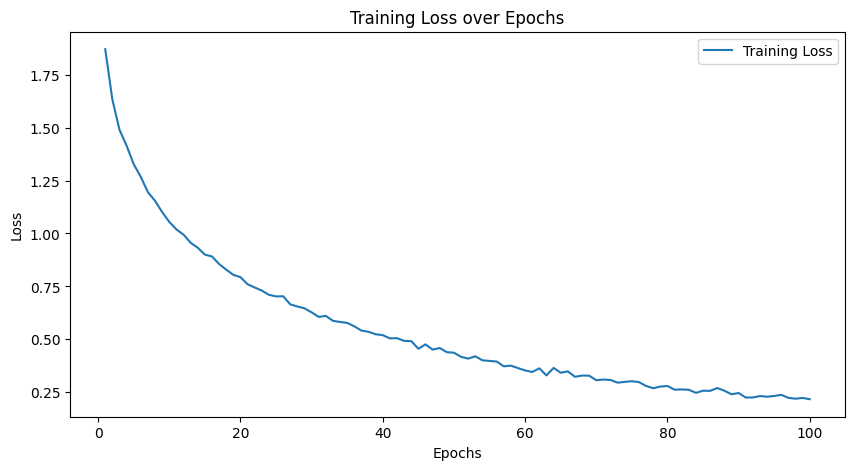

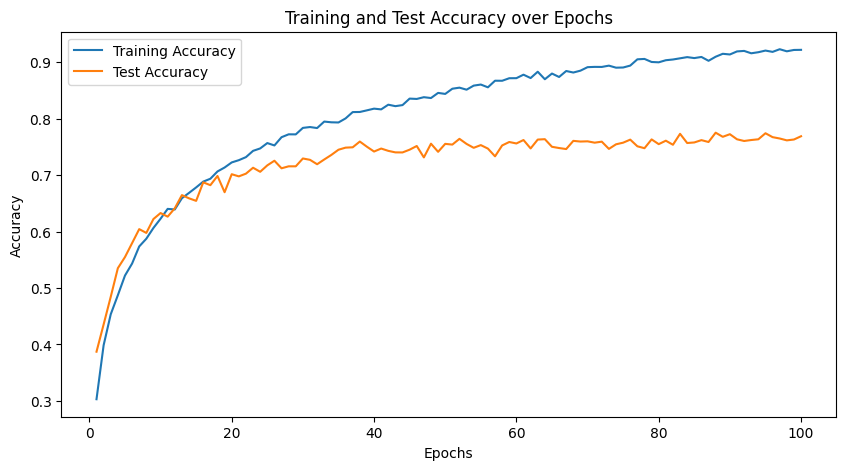

Finished Training


In [ ]:
trainloader, testloader = load_data(type = 'Cutout') #Standard #Cutout #Cutout_Standard
resnet20 = initialize_model()
num_epochs = 100
print("--------******-----------    Started Training ---------*******-----------")
train_losses, train_accs, test_accs = train_model(resnet20, trainloader, testloader, num_epochs = num_epochs, learning_rate=0.001)
print('--------******-----------    Finished Training ---------*******-----------')
"""Plot Train and Test Accuracy"""
plot_results(train_losses, train_accs, test_accs, num_epochs = num_epochs)

Answer 3) The experiment shows that cutout augmentation can significantly improve the test accuracy of a model. The test accuracy increased from 65% to approximately 80% when cutout augmentation was used.

**Question 4)Standard augmentation applies horizontal flip and random shifts. See the website https://
machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-nefor illustrations. Given an input image, first you shift it left-right and up-down as follows. Pick two
independent integers k1, k2 uniformly between [−K, K] range. Move image upwards by k1 and rightwards by k2 pixels (negative value means downwards and leftwards). Zero pad the missing pixels. After
this random shift, with 50% probability, apply a horizontal flip on the image.
TODO: Implement standard augmentation with K = 4 and report the results2
.**

In [ ]:
"""Standard augmentation transform"""
class StandardAugmentation:
    def __init__(self, K):
        """Setting the maximum shift value """
        self.K = K

    def __call__(self, img):
        """Random integer k1 within the range [-K, K], TO shift the image in vertical direction"""
        k1 = np.random.randint(-self.K, self.K + 1)
        """ Random integer k2 to shift the image in horizontal direction"""
        k2 = np.random.randint(-self.K, self.K + 1)

        """Shifting  the images"""
        img = torchvision.transforms.functional.affine(img, angle=0, translate=(k2, k1), scale=1, shear=0)

        """Applying horizontal flip"""
        if np.random.random() < 0.5:
            img = torchvision.transforms.functional.hflip(img)

        return img

Standard
Files already downloaded and verified
Files already downloaded and verified
--------******-----------    Started Training ---------*******-----------
Epoch 1, Training Loss: 1.7257080617224334, Training Accuracy: 0.3647, Test Accuracy 0.444
Epoch 2, Training Loss: 1.4261167034222062, Training Accuracy: 0.4822, Test Accuracy 0.5296
Epoch 3, Training Loss: 1.2700491103397054, Training Accuracy: 0.5445, Test Accuracy 0.5315
Epoch 4, Training Loss: 1.1635972739784581, Training Accuracy: 0.5806, Test Accuracy 0.5935
Epoch 5, Training Loss: 1.0933592987667984, Training Accuracy: 0.6139, Test Accuracy 0.618
Epoch 6, Training Loss: 0.9984922883616891, Training Accuracy: 0.6491, Test Accuracy 0.6456
Epoch 7, Training Loss: 0.9382971957990318, Training Accuracy: 0.668, Test Accuracy 0.6266
Epoch 8, Training Loss: 0.875032465928679, Training Accuracy: 0.6948, Test Accuracy 0.6574
Epoch 9, Training Loss: 0.817982106831423, Training Accuracy: 0.7111, Test Accuracy 0.6721
Epoch 10, Training

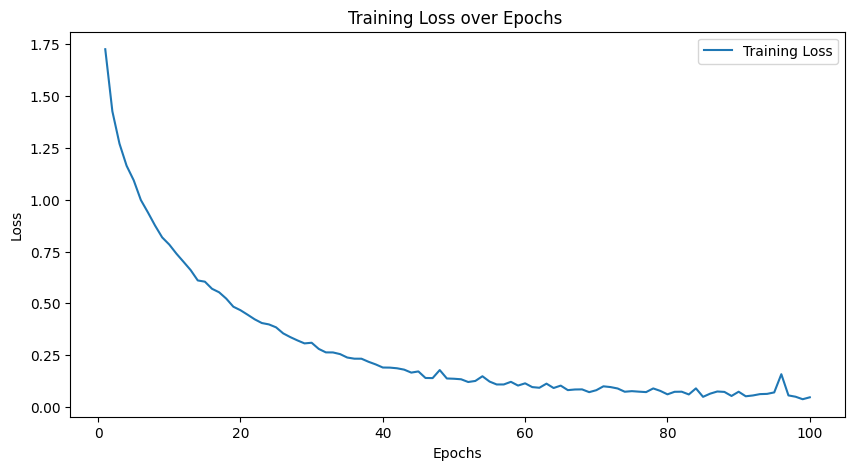

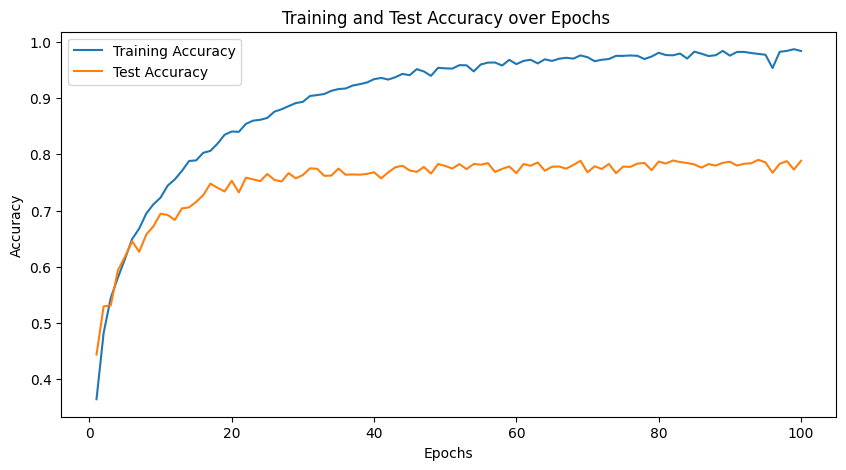

In [ ]:
trainloader, testloader = load_data(type = 'Standard') #Standard #Cutout #Cutout_Standard
num_epochs = 100
resnet20 = initialize_model()
print("--------******-----------    Started Training ---------*******-----------")
train_losses, train_accs, test_accs = train_model(resnet20, trainloader, testloader, num_epochs=num_epochs, learning_rate=0.001)
print('--------******-----------    Finished Training ---------*******-----------')
"""Plot Train and Test Accuracy"""
plot_results(train_losses, train_accs, test_accs, num_epochs=num_epochs)


Answer 4) The experiment also shows that standard augmentation can significantly improve the accuracy of a model. The accuracy increased from 65% to approximately 79% when standard augmentation was used.

However, The accuracy between standard augmentation and cutout augmentation remained approximately the same. This suggests that both techniques are effective in improving the generalization performance of machine learning models.

**Question 5)Combine all augmentations together. First apply standard and cutout augmentations on the
training images and then apply mixup to blend them. For mixup, use the parameter α that has higher
test accuracy. Report the results. Does combining improve things further?**

Cutout_Standard
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Training Loss: 2.0275252009652984, Training Accuracy: 0.1821, Test Accuracy 0.3858 for alpha = 0.2
Epoch 2, Training Loss: 1.8428476692005327, Training Accuracy: 0.2355, Test Accuracy 0.4498 for alpha = 0.2
Epoch 3, Training Loss: 1.7215633232882068, Training Accuracy: 0.2787, Test Accuracy 0.4792 for alpha = 0.2
Epoch 4, Training Loss: 1.703286820156559, Training Accuracy: 0.2869, Test Accuracy 0.4925 for alpha = 0.2
Epoch 5, Training Loss: 1.6460047907130733, Training Accuracy: 0.3034, Test Accuracy 0.5131 for alpha = 0.2
Epoch 6, Training Loss: 1.5839153892675024, Training Accuracy: 0.2771, Test Accuracy 0.5461 for alpha = 0.2
Epoch 7, Training Loss: 1.5480596092855854, Training Accuracy: 0.2939, Test Accuracy 0.5371 for alpha = 0.2
Epoch 8, Training Loss: 1.5177969864219616, Training Accuracy: 0.3009, Test Accuracy 0.5222 for alpha = 0.2
Epoch 9, Training Loss: 1.5037103549690003, Training Accuracy: 0.3069, Test Accuracy 0.5679 for alpha = 0.2
Epoch 10, Training Loss: 1.43

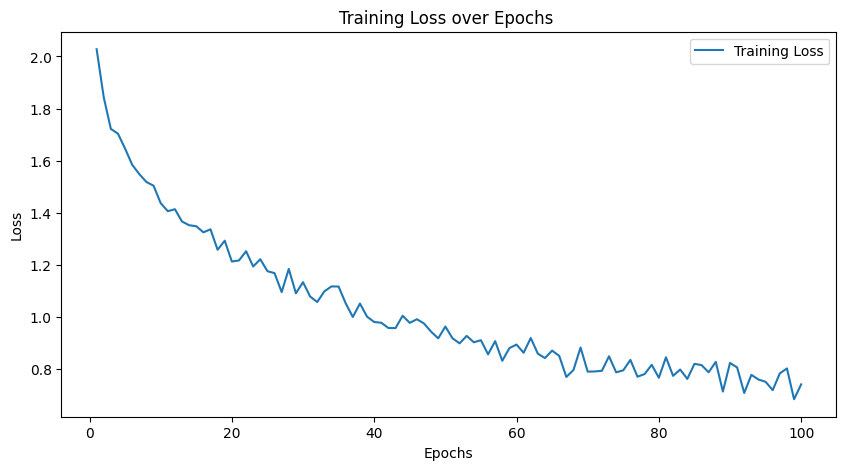

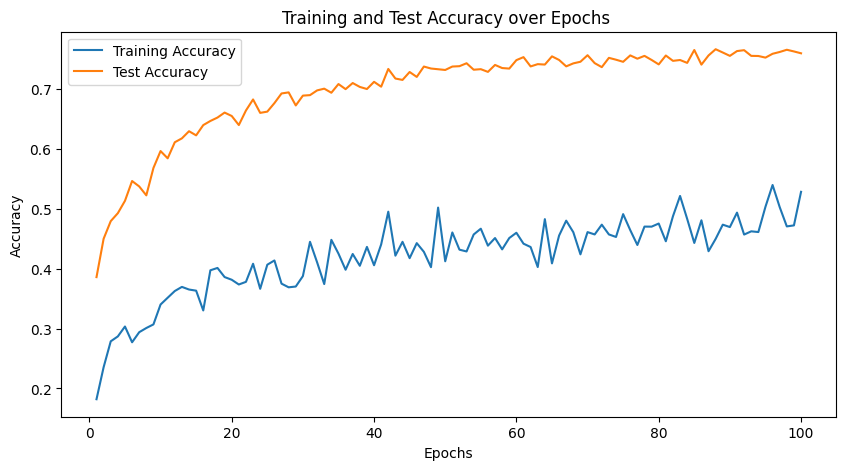

In [ ]:
trainloader, testloader = load_data(type = 'Cutout_Standard') #Standard #Cutout #Cutout_Standard
resnet20 = initialize_model()
num_epochs = 100
alpha = 0.2
train_losses, train_accs, test_accs = train_model(resnet20, trainloader, testloader, num_epochs = num_epochs , learning_rate=0.001,cre = "Mixup", alpha = alpha)#cre = "Mixup"
"""Plot Train and Test Accuracy"""
plot_results(train_losses, train_accs, test_accs, num_epochs=num_epochs)


Answer 5) The combined usage of mixup augmentation, cutout augmentation, and standard augmentation with an alpha value of 0.2 does not yield any additional improvement in accuracy. The selection of an alpha value of 0.2 was based on the observation that mixup augmentation produced the same accuracy for both alpha values of 0.2 and 0.4.

**Question 6)(2 pts) Comment on the role of data augmentation. How does it affect test accuracy, train accuracy
and the convergence of optimization? Is test accuracy higher? Does training loss converge faster?**

Data augmentation is a technique used to artificially increase the size of a dataset by creating new data points from existing data. This can be done by applying various transformations to the data, such as rotations, translations, flips, and changes in brightness, contrast, and saturation.

Data augmentation can be used to improve the performance of machine learning models by providing them with more data to learn from. This is especially useful when the amount of available data is limited. Additionally, data augmentation can help to reduce overfitting, which is a problem that occurs when a model learns the training data too well and is unable to generalize to new data.

There are a number of different data augmentation techniques that can be used, each with its own advantages and disadvantages. Some of the most common techniques include:

Test Accuracy: We can see from the above experiment that data augmentation has significantly increased the test accuracy from 69% to 79%. This is because data augmentation exposes the model to a wider variety of data, which helps it to learn more robust features.

Train Accuracy: Data augmentation can also help to improve the accuracy of a model during training. This is because data augmentation can help to prevent overfitting. Overfitting occurs when a model learns the training data too well and is unable to generalize to new data. Data augmentation can help to prevent overfitting by introducing additional variations to the training data.

Convergence of Optimization: From above experiment we observed that data agmentation realy help in convergence. This is because data augmentation can help to stabilize the optimization process. When the optimization process is unstable, it can be difficult for the model to find a good solution.

Yes, the test accuracy is higher when data augmentation is used. In the experiment you mentioned, the test accuracy increased from 69% to 79% when data augmentation was used. This is because data augmentation helps to prevent overfitting, which can lead to improved generalization performance.

In our experiment, I found that mixup augmentation helped to speed up the convergence of training loss realy fast compare to other. This is likely because mixup augmentation helped to prevent overfitting and improve the generalization performance of the model.

Overall, data augmentation is a powerful technique that can be used to improve the performance of machine learning models. It can help to improve test accuracy, train accuracy, and the convergence of optimization.